## 베이즈 텍스트 분석

다루는 내용
--

- 메일이 스팸메일인지 아닌지 예측

데이터
--
- https://goo.gl/2WWtcs

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

데이터 읽기
--

In [2]:
# data from 'https://www.kaggle.com/ishansoni/sms-spam-collection-dataset/data'
sms = pd.read_csv('data/spam.csv', encoding = 'latin-1')   
sms.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [3]:
# Drop the extra columns and rename columns to make it look the same as the text

sms = sms.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
sms.columns = ["type", "text"]

In [4]:
sms.head(10)

type                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

In [5]:
sms.shape

(5572, 2)

In [6]:
sms['type'].value_counts()

ham     4825
spam     747
Name: type, dtype: int64

In [7]:
sms_corpus = sms['text'] 

In [8]:
type(sms_corpus)

pandas.core.series.Series

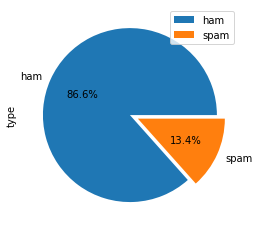

In [9]:
sms['type'].value_counts().plot(kind='pie', explode=[0, 0.1], autopct='%1.1f%%')
plt.legend(['ham', 'spam'])
plt.show()

단어-벡터 생성
--

In [10]:
"""
Bag-of-words model - Wikipedia
다음의 두 문장이 있다고 하자,

(1) John likes to watch movies. Mary likes movies too.
(2) John also likes to watch football games.
위 두 문장을 토큰화하여 가방에 담아주면 다음과 같다.

[
    "John",
    "likes",
    "to",
    "watch",
    "movies",
    "Mary",
    "too",
    "also",
    "football",
    "games"
]
그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.

(1) [1, 2, 1, 1, 2, 1, 1, 0, 0, 0]
(2) [1, 1, 1, 1, 0, 0, 0, 1, 1, 1]
=> 머신러닝 알고리즘이 이해할 수 있는 형태로 바꿔주는 작업이다.

단어 가방을 n-gram을 사용해 bigram으로 담아주면 다음과 같다.

[
    "John likes",
    "likes to",
    "to watch",
    "watch movies",
    "Mary likes",
    "likes movies",
    "movies too",
]
=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.
"""

'\nBag-of-words model - Wikipedia\n다음의 두 문장이 있다고 하자,\n\n(1) John likes to watch movies. Mary likes movies too.\n(2) John also likes to watch football games.\n위 두 문장을 토큰화하여 가방에 담아주면 다음과 같다.\n\n[\n    "John",\n    "likes",\n    "to",\n    "watch",\n    "movies",\n    "Mary",\n    "too",\n    "also",\n    "football",\n    "games"\n]\n그리고 배열의 순서대로 가방에서 각 토큰이 몇 번 등장하는지 횟수를 세어준다.\n\n(1) [1, 2, 1, 1, 2, 1, 1, 0, 0, 0]\n(2) [1, 1, 1, 1, 0, 0, 0, 1, 1, 1]\n=> 머신러닝 알고리즘이 이해할 수 있는 형태로 바꿔주는 작업이다.\n\n단어 가방을 n-gram을 사용해 bigram으로 담아주면 다음과 같다.\n\n[\n    "John likes",\n    "likes to",\n    "to watch",\n    "watch movies",\n    "Mary likes",\n    "likes movies",\n    "movies too",\n]\n=> 여기에서는 CountVectorizer를 통해 위 작업을 한다.\n'

### 사이킷런의 CountVectorizer를 통해 피처 생성
- 정규표현식을 사용해 토큰을 추출한다.
- 모두 소문자로 변환시키기 때문에 good, Good, gOod이 모두 같은 특성이 된다.
- 의미 없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
- min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [11]:
# countvectorizer: Convert a collection of text documents to a matrix of token counts
# example
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
        'This is the first document.',
        'This document is the second document.',
        'And this is the third one.',
        'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

In [12]:
print(X)
print(vectorizer.get_feature_names())
print(X.toarray())
X.shape

  (0, 8)	1
  (0, 3)	1
  (0, 6)	1
  (0, 2)	1
  (0, 1)	1
  (1, 8)	1
  (1, 3)	1
  (1, 6)	1
  (1, 1)	2
  (1, 5)	1
  (2, 8)	1
  (2, 3)	1
  (2, 6)	1
  (2, 0)	1
  (2, 7)	1
  (2, 4)	1
  (3, 8)	1
  (3, 3)	1
  (3, 6)	1
  (3, 2)	1
  (3, 1)	1
['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


(4, 9)

In [13]:
vectorizer = CountVectorizer(min_df=10) # 10번 이하로 발생한 단어 무시
X = vectorizer.fit_transform(sms_corpus)
X.shape

(5572, 1016)

In [14]:
len(vectorizer.get_feature_names())

1016

In [15]:
y = sms['type'] 
y[:5]

0     ham
1     ham
2    spam
3     ham
4     ham
Name: type, dtype: object

In [16]:
# X.toarray()

In [17]:
X[:5].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [18]:
maxidx = X[:5].toarray().argmax(axis=1); maxidx

array([ 92, 460, 862, 728, 391], dtype=int64)

In [50]:
maxcounts = [X[:5].toarray()[i,j] for i, j  in enumerate(maxidx)]
print(maxcounts)
X[:5].toarray().max(axis=1)

[1, 1, 3, 2, 2]


array([1, 1, 3, 2, 2], dtype=int64)

In [36]:
# vectorizer.get_feature_names()
maxwords = [vectorizer.get_feature_names()[i] for i in maxidx]    # list
maxwords

['available', 'lar', 'to', 'say', 'he']

In [92]:
# 전체 max 단어
print(X.toarray().sum(0).max())
print(X.toarray().sum(0).argmax())
vectorizer.get_feature_names()[X.toarray().sum(0).argmax()]

2242
862


'to'

In [91]:
# 전체 5개 max 단어
iidx = X.toarray().sum(0).argsort()[-5:][::-1]
print(iidx)
print([vectorizer.get_feature_names()[i] for i in iidx])
print([X.toarray().sum(0)[i] for i in iidx])

[ 862 1007  836   67  432]
['to', 'you', 'the', 'and', 'in']
[2242, 2240, 1328, 979, 898]


In [85]:
############ exercise #############
# list 연습
list = [1,2,3,4,5]
good=[0,2]
good_list = [list[i] for i in good]
good_list

# argmax 연습
a = np.arange(6).reshape(2,3) + 10
print(a)
np.argmax(a)
np.argmax(a, axis=0)
np.argmax(a, axis=1)


[[10 11 12]
 [13 14 15]]


In [37]:
type(X), type(y), y.head()

(scipy.sparse.csr.csr_matrix, pandas.core.series.Series, 0     ham
 1     ham
 2    spam
 3     ham
 4     ham
 Name: type, dtype: object)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.25)

베이즈 알고리즘 적용
--

In [39]:
clf = GaussianNB() 
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test).round(4))

0.7968


In [40]:
y_predict = clf.predict(X_test) 
print(metrics.classification_report(y_test, y_predict)) 

              precision    recall  f1-score   support

         ham       0.99      0.78      0.87      1223
        spam       0.37      0.92      0.53       170

    accuracy                           0.80      1393
   macro avg       0.68      0.85      0.70      1393
weighted avg       0.91      0.80      0.83      1393



In [41]:
print(metrics.confusion_matrix(y_test, y_predict))   # known to be in i, predicted in j
                                                     # (0,0):true neg, (1,0): false neg, (1,1): true pos, (0,1): false pos)

[[953 270]
 [ 13 157]]


In [42]:
#             0(no)     1(spam)
#   0(n0)      942          255
#   1(spam)     8           188        recall_spam = 188/196

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [44]:
mod1 = SGDClassifier()
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9827709978463748

In [45]:
mod1 = RandomForestClassifier(n_estimators=100)
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9820531227566404

In [46]:
mod1 = DecisionTreeClassifier()
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9669777458722182

In [47]:
mod1 = LogisticRegression()
mod1.fit(X_train, y_train)
mod1.score(X_test, y_test)

0.9798994974874372